# Sistemas de recomendación

###Carga de datos de Movie Lens

In [295]:
import pandas as pd
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
data = pd.read_csv(url, sep='\t', header = None)
data.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [296]:
data.shape

(100000, 4)

In [297]:
data.columns = ['user_ID', 'item_ID', 'rating', 'timestamp']
data.head()

,user_ID,item_ID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Análisis exploratorio de los items

In [298]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

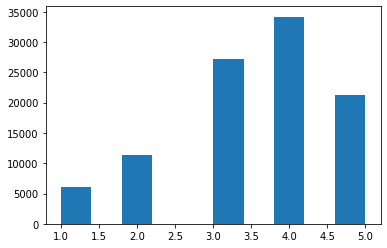

In [299]:
plt.hist(data.rating)

(array([11459.,  5724., 19359.,  9315.,  9396., 10083.,  6175.,  9603.,
        10048.,  8838.]),
 array([8.74724710e+08, 8.76580903e+08, 8.78437096e+08, 8.80293288e+08,
        8.82149481e+08, 8.84005674e+08, 8.85861867e+08, 8.87718060e+08,
        8.89574252e+08, 8.91430445e+08, 8.93286638e+08]),
 <a list of 10 Patch objects>)

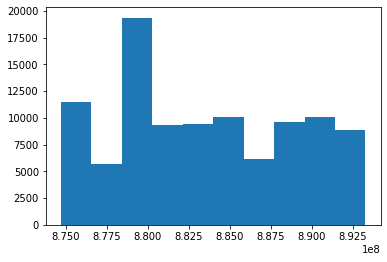

In [300]:
plt.hist(data.timestamp)

In [301]:
data.groupby(['rating'])['user_ID'].count()

rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: user_ID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

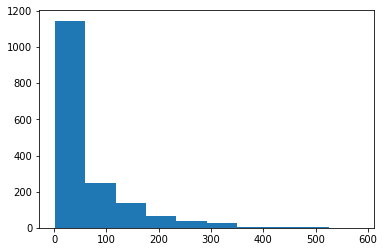

In [302]:
plt.hist(data.groupby(['item_ID'])['item_ID'].count())

### Representación en forma matricial




In [303]:
n_users = data.user_ID.unique().shape[0]
n_users

943

In [304]:
n_items = data.item_ID.unique().shape[0]
n_items

1682

In [305]:
import numpy as np

ratings = np.zeros((n_users, n_items))

for row in data.itertuples():
  ratings[row[1]-1, row[2]-1] = row[3]

In [306]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [307]:
sparsity = float(len(ratings.nonzero()[0]))/(ratings.shape[0] * ratings.shape[1]) * 100
print('El coeficiente de sparseidad: {:4.2f}%'.format(sparsity))
#Esto significa que el 6,30% de la matriz no son ceros, pero todo el resto sí (ausencia de valoración)

El coeficiente de sparseidad: 6.30%


###Crear conjuntos de entrenamiento y validación

In [308]:
from sklearn.model_selection import train_test_split

In [309]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.30, random_state = 42)

In [310]:
ratings_train.shape

(660, 1682)

In [311]:
ratings_test.shape

(283, 1682)

###Filtro colaborativo basado en Usuarios

* Matriz de similaridad entre los usuarios (distancia del coseno). Ojo que distancia y coseno son inversamente proporcionales, por eso se hace un cambio como 1 - distancia.

* Predecir la valoración desconocida de un item *i* para un usuario activo *u* basándonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem

* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.


In [312]:
import numpy as np
import sklearn

In [313]:
sim_matrix_train = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)
sim_matrix_train #La matriz es simétrica

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [314]:
sim_matrix_train.shape

(660, 660)

In [315]:
user_predictions_train = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis = 1)]).T
user_predictions_train

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [316]:
user_predictions_train.shape

(660, 1682)

In [317]:
sim_matrix_test = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_test)
sim_matrix_test #La matriz es simétrica

array([[1.        , 0.01775916, 0.        , ..., 0.28350676, 0.16604346,
        0.        ],
       [0.01775916, 1.        , 0.10949965, ..., 0.09149486, 0.10727161,
        0.29149166],
       [0.        , 0.10949965, 1.        , ..., 0.08713681, 0.        ,
        0.28879086],
       ...,
       [0.28350676, 0.09149486, 0.08713681, ..., 1.        , 0.19793486,
        0.03893564],
       [0.16604346, 0.10727161, 0.        , ..., 0.19793486, 1.        ,
        0.07977195],
       [0.        , 0.29149166, 0.28879086, ..., 0.03893564, 0.07977195,
        1.        ]])

In [318]:
sim_matrix_test.shape

(283, 283)

In [319]:
user_predictions_test = sim_matrix_test.dot(ratings_test) / np.array([np.abs(sim_matrix_test).sum(axis = 1)]).T
user_predictions_test

array([[2.47537469e+00, 7.01507002e-01, 3.70391107e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.73649392e+00, 2.54530419e-01, 2.29995340e-01, ...,
        9.19630908e-03, 0.00000000e+00, 0.00000000e+00],
       [1.27891613e+00, 2.42958428e-01, 1.52385690e-01, ...,
        1.99425992e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.32444820e+00, 6.51072887e-01, 3.72683157e-01, ...,
        1.27657170e-03, 0.00000000e+00, 0.00000000e+00],
       [2.03330183e+00, 4.94112870e-01, 3.04957161e-01, ...,
        2.90605858e-03, 0.00000000e+00, 0.00000000e+00],
       [1.03844171e+00, 2.22612289e-01, 1.27654854e-01, ...,
        2.03317109e-02, 0.00000000e+00, 0.00000000e+00]])

In [320]:
user_predictions_test.shape

(283, 1682)

In [321]:
from sklearn.metrics import mean_squared_error

In [322]:
def get_mse(preds, actuals):
  if preds.shape[0] != actuals.shape[0]:
    actuals = actuals.T
  preds = preds[actuals.nonzero()].flatten()
  actuals = actuals[actuals.nonzero()].flatten()
  return mean_squared_error(preds, actuals)

In [323]:
get_mse(user_predictions_train, ratings_train) 

7.878218313143215

In [324]:
get_mse(user_predictions_test, rating_test)

7.51355110112698

### Filtrado colaborativo basado en los KNN

In [325]:
from sklearn.neighbors import NearestNeighbors

In [326]:
k = 10

In [327]:
neighbors = NearestNeighbors(k, 'cosine')

In [328]:
neighbors.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius='cosine')

In [329]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance = True)

In [330]:
top_k_distances.shape

(660, 10)

In [331]:
top_k_users.shape

(660, 10)

In [332]:
users_predict_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]): #Para cada usuario del conjunto de entrenamiento
  users_predict_k[i, :] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis = 0)]).T

In [333]:
users_predict_k.shape

(660, 1682)

In [334]:
users_predict_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66502836, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.31240293, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [335]:
get_mse(users_predict_k, ratings_train)

8.229125487414281

### Filtro colaborativo basado en Items

In [336]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [337]:
neighbors = NearestNeighbors(n_movies, 'cosine')
neighbors

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1682, p=2,
                 radius='cosine')

In [338]:
neighbors.fit(ratings_train.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1682, p=2,
                 radius='cosine')

In [339]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance = True)

In [340]:
top_k_distances.shape

(1682, 1682)

In [341]:
top_k_items.shape

(1682, 1682)

In [342]:
item_prediction = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis = 1)])

In [343]:
item_prediction.shape

(660, 1682)

In [344]:
get_mse(item_prediction, ratings_train)

11.172565375125632

In [345]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1565, 1571, 1570, ...,  180,   99,   49],
       [1680, 1671, 1582, ...,  180,   99,   49],
       [1681, 1596, 1592, ...,  180,   99,   49]])

In [346]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.item'
movies = pd.read_csv(url, sep='|', header = None, encoding = "ISO-8859-1")
movies.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [347]:
movies.iloc[top_k_items[0]][1]


0                     Toy Story (1995)
120      Independence Day (ID4) (1996)
404         Mission: Impossible (1996)
116                   Rock, The (1996)
221    Star Trek: First Contact (1996)
                    ...               
271           Good Will Hunting (1997)
268             Full Monty, The (1997)
285        English Patient, The (1996)
312                     Titanic (1997)
301           L.A. Confidential (1997)
Name: 1, Length: 1682, dtype: object

In [348]:
top_k_items[0].shape

(1682,)

### Filtrado colaborativo basado en KNN

In [349]:
k = 30

In [350]:
neighbors = NearestNeighbors(k, 'cosine')

In [351]:
neighbors.fit(ratings_train.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                 radius='cosine')

In [352]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance = True)

In [353]:
top_k_distances.shape

(1682, 30)

In [354]:
top_k_items.shape

(1682, 30)

In [355]:
movies.iloc[top_k_items[0]][1]

0                                  Toy Story (1995)
120                   Independence Day (ID4) (1996)
404                      Mission: Impossible (1996)
116                                Rock, The (1996)
221                 Star Trek: First Contact (1996)
150    Willy Wonka and the Chocolate Factory (1971)
117                                  Twister (1996)
180                       Return of the Jedi (1983)
6                             Twelve Monkeys (1995)
741                                   Ransom (1996)
27                                 Apollo 13 (1995)
94                                   Aladdin (1992)
256                             Men in Black (1997)
236                            Jerry Maguire (1996)
124                               Phenomenon (1996)
81                             Jurassic Park (1993)
24                             Birdcage, The (1996)
587                     Beauty and the Beast (1991)
227             Star Trek: The Wrath of Khan (1982)
110         

In [356]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
  preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i]) / np.array([np.abs(top_k_distances[i]).sum(axis = 0)]).T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [357]:
get_mse(preds, ratings_train)

8.732017359673444